# Computer Vision - Assignment 2 - Convolutional Neural Networks for Image Classification

#### 10 (+3) points   |   Due date: November 25 23:59   |   Submission site: https://pradogrado2223.ugr.es/

### Student's Full Name: <mark>Juan Miguel Gómez Daza</mark>

The goal of this assignment is to learn how to implement and use CNN models using the Fastai library. 

The goal of this assignmnet is to gain experience designing and training convolutional neural networks, using fast.ai. From a base network architecture that is provided, you have to learn to experiment with it and improve it by adding, modifying or deleting layers from this architecture in the task of classifying images into 25 categories. To carry out this assignment, a help guide is provided to know how:
1. Basic functions of reading data, training and optimization can be performed;
2. Graphs for the evolution of the classification error in
the training and validation sets can be created;
3. The classification error in the test set can be computed.

In [1]:
import sys
import subprocess
import pkg_resources

required = {'nbdev', 'fastbook'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed
print(missing)

if 'nbdev' in missing:
    print("INSTALLING nbdev")
    !pip install nbdev
!pip list |grep nbdev    
if 'fastbook' in missing:
    print("INSTALLING fastbook")
    !pip install -Uqq fastbook
!pip list |grep fastbook

{'fastbook', 'nbdev'}
INSTALLING nbdev
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 962 kB/s 
     |████████████████████████████████| 58 kB 1.7 MB/s 
     |████████████████████████████████| 78 kB 3.7 MB/s 
     |████████████████████████████████| 1.6 MB 70.5 MB/s 
nbdev                         2.3.9
INSTALLING fastbook
     |████████████████████████████████| 719 kB 5.1 MB/s 
     |████████████████████████████████| 1.3 MB 7.5 MB/s 
     |████████████████████████████████| 5.5 MB 47.1 MB/s 
     |████████████████████████████████| 451 kB 50.6 MB/s 
     |████████████████████████████████| 132 kB 65.0 MB/s 
     |████████████████████████████████| 182 kB 63.2 MB/s 
     |████████████████████████████████| 212 kB 34.8 MB/s 
     |████████████████████████████████| 127 kB 49.3 MB/s 
     |████████████████████████████████| 7.6 MB 48.6 MB/s 
fastbook                      0.0.29


In [2]:
# The first thing we should do is to apply hardware acceleration via GPU. So, we have to go to Editar - Configuracion del Cuaderno - Acelerador por Hardware GPU

# Now we SET UP Fastai
import fastbook
fastbook.setup_book()
import fastai
import fastcore
print(f'fastcore version {fastcore.__version__} installed')
print(f'fastai version {fastai.__version__} installed')
from nbdev.showdoc import *
from fastai.vision.all import *

Mounted at /content/gdrive
fastcore version 1.5.27 installed
fastai version 2.7.10 installed


In [3]:
# Function to display evaluation metrics

@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()



---



---



---



# **Exercise 1:** BaseNet in CIFAR100 (4 points)

*Dataset:*
In this exercise, we will work with part of the CIFAR100 dataset. This dataset consists of 60K color images of 32x32x3 (RGB) depicting 100 different classes (600 images per class). There are 50K images for training and 10K for testing. For the development of the exercise we will only consider 25 classes (out of 100). Therefore, the training set has 12,500 images and the test set 2,500 images. 10% of the training set will be used for validation. 

**Model BaseNet:**
We start by creating a base model called *BaseNet* which, after its training and execution, will give us a classification error which will be used as reference or baseline for further improvements. In order to create it (and later improve it), we will use a sensible combination of the following layers:
- Convolutional layers (Conv2D, either normal or atrous), 
- Pooling layers (Local and Global MaxPooling2D and AveragePooling2D), 
- Dense layers (also called fully connected layers), 
- Non-linear activations, (e.g. ReLu, leaky ReLu, etc.), 
- Flattening (i.e. convert 2D features to 1D features),  
- Batch Normalization, 
- and Regularization (e.g. Dropout or weight decay).

Our BaseNet model consists of two convolutional layers (conv-relu) at different scales (MaxPooling2D), and one head composed of two linear layers (i.e. two dense layers). The precise architecture is defined in the table below:

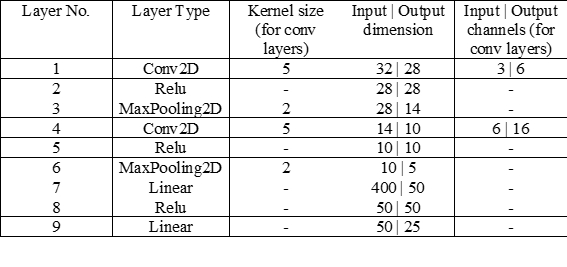

The students must:

1. Become familiar with the *BaseNet* architecture described above, the meaning of the different hyperparameters and the purpose of each layer. Create the code for the *BaseNet* model employing the fastai library, and using any of the techniques shown in the help guide.
2. Train the model and compute the values of “accuracy” and loss function for both training and test sets. Present the results using the provided functions.

In [4]:
# We get the CIFAR100 dataset
path = untar_data(URLs.CIFAR_100,force_download=True)

In [5]:
# The CIFAR_100 dataset, as well as the MNIST dataset, follows a common layout for machine learning datasets: 
# separate folders for the training set and the validation set (and/or test set). 
# Let's see what's inside both the training and test sets
print(path)
print(path.ls())
print((path/'train').ls())
print((path/'test').ls())
train_classes = (path/'train').ls()
test_classes = (path/'test').ls()
print(len(train_classes))

/root/.fastai/data/cifar100
[Path('/root/.fastai/data/cifar100/train'), Path('/root/.fastai/data/cifar100/test')]
[Path('/root/.fastai/data/cifar100/train/household_furniture'), Path('/root/.fastai/data/cifar100/train/small_mammals'), Path('/root/.fastai/data/cifar100/train/large_natural_outdoor_scenes'), Path('/root/.fastai/data/cifar100/train/large_omnivores_and_herbivores'), Path('/root/.fastai/data/cifar100/train/vehicles_1'), Path('/root/.fastai/data/cifar100/train/aquatic_mammals'), Path('/root/.fastai/data/cifar100/train/large_carnivores'), Path('/root/.fastai/data/cifar100/train/insects'), Path('/root/.fastai/data/cifar100/train/large_man-made_outdoor_things'), Path('/root/.fastai/data/cifar100/train/non-insect_invertebrates'), Path('/root/.fastai/data/cifar100/train/vehicles_2'), Path('/root/.fastai/data/cifar100/train/people'), Path('/root/.fastai/data/cifar100/train/fruit_and_vegetables'), Path('/root/.fastai/data/cifar100/train/medium_mammals'), Path('/root/.fastai/data/cif

This dataset is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. **The 100 classes in the CIFAR-100 are grouped into 20 superclasses**. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs).

In [6]:
files_train = get_image_files(path/'train')
files_test = get_image_files(path/'test')
print('Total training images: ', len(files_train))
print('Total test images: ', len(files_test))

Total training images:  50000
Total test images:  10000


We now keep the first 25 classes. To do so, we remove the last 75 from the dataset.

In [7]:
#https://stackoverflow.com/questions/185936/how-to-delete-the-contents-of-a-folder
import shutil
number_of_classes_to_keep = 25
number_of_superclasses_to_keep = int(number_of_classes_to_keep/5)
print('SUPERCLASSES DELETED:')
for i in range(number_of_superclasses_to_keep,len(train_classes)):
  print(train_classes[i])
  shutil.rmtree(train_classes[i]) 
print('SUPERCLASSES KEPT:')
for i in range(number_of_superclasses_to_keep):
  print(train_classes[i])

SUPERCLASSES DELETED:
/root/.fastai/data/cifar100/train/aquatic_mammals
/root/.fastai/data/cifar100/train/large_carnivores
/root/.fastai/data/cifar100/train/insects
/root/.fastai/data/cifar100/train/large_man-made_outdoor_things
/root/.fastai/data/cifar100/train/non-insect_invertebrates
/root/.fastai/data/cifar100/train/vehicles_2
/root/.fastai/data/cifar100/train/people
/root/.fastai/data/cifar100/train/fruit_and_vegetables
/root/.fastai/data/cifar100/train/medium_mammals
/root/.fastai/data/cifar100/train/reptiles
/root/.fastai/data/cifar100/train/household_electrical_devices
/root/.fastai/data/cifar100/train/fish
/root/.fastai/data/cifar100/train/flowers
/root/.fastai/data/cifar100/train/food_containers
/root/.fastai/data/cifar100/train/trees
SUPERCLASSES KEPT:
/root/.fastai/data/cifar100/train/household_furniture
/root/.fastai/data/cifar100/train/small_mammals
/root/.fastai/data/cifar100/train/large_natural_outdoor_scenes
/root/.fastai/data/cifar100/train/large_omnivores_and_herbivo

In [8]:
# We also remove the same superclasses from the test set
for i in range(number_of_superclasses_to_keep,len(test_classes)):
  print(test_classes[i])
  shutil.rmtree(test_classes[i]) 

/root/.fastai/data/cifar100/test/aquatic_mammals
/root/.fastai/data/cifar100/test/large_carnivores
/root/.fastai/data/cifar100/test/insects
/root/.fastai/data/cifar100/test/large_man-made_outdoor_things
/root/.fastai/data/cifar100/test/non-insect_invertebrates
/root/.fastai/data/cifar100/test/vehicles_2
/root/.fastai/data/cifar100/test/people
/root/.fastai/data/cifar100/test/fruit_and_vegetables
/root/.fastai/data/cifar100/test/medium_mammals
/root/.fastai/data/cifar100/test/reptiles
/root/.fastai/data/cifar100/test/household_electrical_devices
/root/.fastai/data/cifar100/test/fish
/root/.fastai/data/cifar100/test/flowers
/root/.fastai/data/cifar100/test/food_containers
/root/.fastai/data/cifar100/test/trees


Now we verify if we have removed them correctly. 

In [9]:
print(path)
train_classes = (path/'train').ls()
test_classes = (path/'test').ls()
print(len(train_classes))
print(len(test_classes))

/root/.fastai/data/cifar100
5
5


And that the number of examples is correct

In [10]:
files_train = get_image_files(path/'train')
files_test = get_image_files(path/'test')
print('Total training images: ', len(files_train))
print('Total test images: ', len(files_test))

Total training images:  12500
Total test images:  2500


Now we should have 12500 images for training and 2500 images for testing. 

Next, \
1.- you have to employ DataLoaders and DataBlock to load the data. \
2.- you have to define the Learner\
3.- you have to train the model \

# **Solución:**

Definimos el DataBlock haciendo que cada bloque sea un par imagen-etiqueta, la imagen se obtiene por medio de la funcion get_image_files del path y la etiqueta del directorio en que se encuentra la imagen. Además dejaremos el 10% de los datos para validación y el resto para entrenamiento. Como la arquitectura propuesta tiene una imagen de 32x32x3 tendremos que hacer un resize de las imagenes del dataset.

En el Dataloader cargamos los datos con los que se va a entrenar y seleccionamos el tamaño del batch. El batch es un subconjunto del conjunto de entrenamiento que utilizamos para entrenar el modelo, un tamaño pequeño hará uso de menos memoria y además se entrenará más rápido. En este caso yo he escogido un valor más bien pequeño. 

Luego se ha definido el modelo con la arquitectura especificada en el enunciado. Un error que he encontrado mientras lo implementaba era que no había incluido la capa nn.Flatten() y entonces la entrada de la FCL no era la adecuada. Como se ha comentado en clase, aunque yo no pude asistir, la capa SoftMax no tenemos que añadirla ya que vamos a usar CrossEntropyLossFlat().

Creamos el objeto learner con el Dataloader y el modelo que hemos definido antes. Además indicamos que use como función de perdida CrossEntropyLossFlat(), y como métrica, es decir lo que va a mostrar tras cada época, el accuracy.

Con el método summary() del objeto learn visualizamos nuestro modelo al completo, el número de parametros que utiliza, funciones de perdida y algoritmo de optmización, asi como las dimensiones de los volumenes.

In [11]:
# Setting the model
# len(example)
dbl = DataBlock(
    blocks=(ImageBlock, CategoryBlock), #define el input
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct=0.1, seed=42),
    get_y = parent_label,
    item_tfms = [Resize(32)]
    )

dls = dbl.dataloaders(path/'train', bs=64)

baseNet = sequential( #Softmax lo hace al final
    nn.Conv2d(in_channels=3, out_channels=6, kernel_size=(5,5)),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2)),
    nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5,5)),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2)),
    nn.Flatten(), # no estaba haciendo esto y tenia un error que decia que no podian multiplicar 2 matrices
    nn.Linear(in_features=400, out_features=50),
    nn.ReLU(),
    nn.Linear(in_features=50, out_features=25),
)

from torch.nn.modules.loss import CrossEntropyLoss

learn = Learner(dls, baseNet, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

learn.summary()

Sequential (Input shape: 64 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 6 x 28 x 28    
Conv2d                                    456        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 6 x 14 x 14    
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 16 x 10 x 10   
Conv2d                                    2416       True      
ReLU                                                           
____________________________________________________________________________
                     64 x 16 x 5 x 5     
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 400    

Ahora lo siguiente es entrenar el modelo, para ello utilizaremos el método fit_one_cycle. Este método utiliza la política One Cycle de Leslie N. Smith. Frente a el entrenamiento clásico donde usamos un Learning Rate fijo todo el rato, esta política hace uso de un Momentum y un Learning Rate que va creciendo y decreciendo a lo largo de la época y esto hace que se entrene más rápido. Por tanto es necesario especificar el Learning Rate máximo que usaremos durante el entrenamiento. Este Learning Rate máximo lo podemos calcular con el método lr_find().

Para el entrenamiento he usado 10 épocas, un número de épocas pequeño pero suficiente para este modelo tan sencillo que tiene pocos parámetros que entrenar.

A continuación se mostrarán unas tablas con información del proceso de entrenamiento, concretamente nos da el error de entrenamiento, el error de validación y la precisión del modelo para cada época.

Learning rate maximo: 0.010964781977236271


epoch,train_loss,valid_loss,accuracy,time
0,2.873621,2.708800,0.188800,00:15
1,2.564247,2.448366,0.263200,00:15
2,2.371466,2.218970,0.333600,00:18
3,2.212701,2.193340,0.356800,00:15
4,2.085184,2.050086,0.365600,00:15
5,1.886947,1.969041,0.392800,00:17
6,1.764417,1.927098,0.416000,00:15
7,1.604566,1.954755,0.428000,00:15
8,1.462644,1.892103,0.437600,00:15
9,1.419632,1.893167,0.437600,00:15


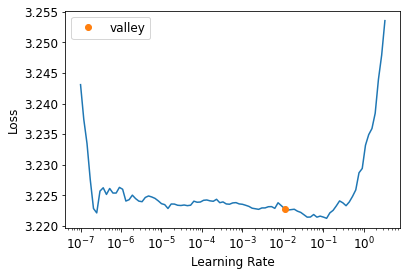

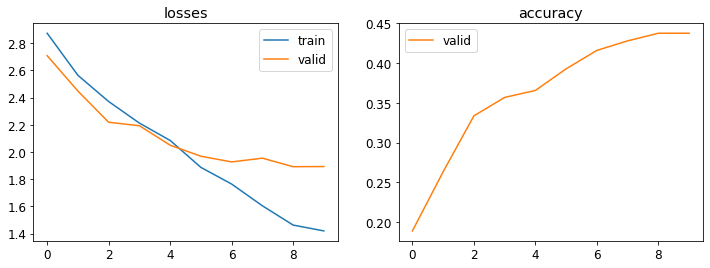

In [12]:
lr = learn.lr_find()
print(f'Learning rate maximo: {lr[0]}')
learn.fit_one_cycle(n_epoch=10, lr_max=lr[0], )
learn.recorder.plot_metrics()

Ahora vamos a calcular el accuracy de nuestro modelo con el conjunto de test que hemos generado antes. Para ello primero generamos un Dataloader que utilice las imagenes que hemos reservado para el test.

Usamos get_preds, un método del objeto learn que nos da las predicciones a partir del Dataloader que se le pase, en este caso el Dataloader de test que hemos generado antes.



In [13]:
test_dl = learn.dls.test_dl(files_test, with_labels=True)
test_dl.show
preds, targs = learn.get_preds(dl=test_dl)

Con la función accuracy obtenemos el acierto de nuestro modelo con los datos del conjunto test.



In [14]:
acc = accuracy(preds, targs)
print('The test accuracy is : ', round(float(acc)*100, 4), '%')

The test accuracy is :  42.48 %


Hemos obtenido un 37.08% de accuracy en nuesto conjunto de test, es decir de cada 100 imagenes clasificará bien el 37. Sobre los resultados obtenidos decir que el accuracy obtenido es muy pequeño y por tanto esta arquitectura no creo que se pudiera como clasificador de imagenes en un sistema real, pero hay que tener en cuenta que el modelo de BaseNet es un modelo muy sencillo y hay muchas posibles mejoras que le podemos aplicar aún y que vamos a probar en el siguiente ejercicio.



---



---



---



# **Exercise 2:** **Improvement of the BaseNet model (3 points)**
Now the goal is to create, by making judicious architectural and implementation choices, an enhanced deep network based on *BaseNet*. A good combination of layers can make the accuracy of the new model close to 50% on our CIFAR100 data. To enhance your network, you may consider adding any combination of the following enhancement options:
1. **Data normalization**. Scale normalization of the input data, in general, makes training easier and more robust. Use the DataLoader or ImageDataLoaders class with the correct parameters so that the data is well conditioned (mean=0, stddev=1) to improve training. You must ensure that test_transform uses the same normalization parameters as train_transform.
2. **Batch normalization**. Batch-normalization layers in most cases help to reduce overfitting and improve model training. Add normalization layers after convolutional layers and before the ReLU layer, but try including it after ReLU layers as well.
3. **Depth increase**. Experiment adding convolutional layers. Do not always put a maxpool layer after each conv layer, as this leads to excessive loss of information by reducing the number of units. If needed use UpSampling (Transposed Convolution) layers to increase the number of units.
4. **Dropout**. This layer introduces regularization by randomly selecting a percentage of active neurons for each mini-batch. This helps the network to specialize neurons in specific and independent information.
5. **Early Stopping**. After how many epochs we should stop training? This answer on stack-exchange (https://datascience.stackexchange.com/questions/18339/why-use-both-validation-set-and-test-set/18346#18346) is a good summary of using train-val-test splits to reduce overfitting. This blog (https://elitedatascience.com/overfitting-in-machine-learning#how-to-prevent) is also a good reference for “early stopping”. Very important: keep in mind that you should never use the test set for anything other than the final evaluation. You should decide for how many epochs you will train your model by looking at the training loss and validation accuracy plots (to do so, evaluate the local minima/maxima of the loss function as well as the classification accuracy). Remember that if you choose too many epochs it would quite likely lead to overfitting, while if you select too few your model quite likely won't  learn enough. In your report, you must include a table similar to the one shown in Exercise 1 to illustrate the architecture of your final improved network. In addition, you must explain the steps taken with the partial results obtained that have finally led you to introduce the proposed modifications.
6. **Data augmentation**.  Use the DataLoader or ImageDataLoaders class data zoom parameters, like zoom_range and/or horizontal_flip. Remember that you should not have any data augmentation in the validation or test sets. If you need a better understanding, try reading Fastai's tutorial on transformations. Look at data augmentation using image transformations.

# **Solución:** 
 Para este ejercicio he implementado todas las mejoras propuestas en el enunciado, aunque en un orden diferente al que aparece arriba. Primero implemente las mejoras que  más aumentaban el accuracy y luego metí el resto de mejoras para que el entrenamiento fuera mejor y asi evitar algunos problemas como por ejemplo el sobreentrenamiento. En el accuracy lo que más repercutió fue añadir mas capas convolucionales, reducir el tamaño de los kernels, y el Batch normalization.

 A continuación voy a comentar como estan incluidas estas mejoras dentro _fastai_ y lo voy a hacer en el orden que aparecen en el código.

 En primer lugar definimos el Datablock de forma similar a como lo hicimos en el primer ejercicio, el bloque es un par imagen-categoria, el conjunto de validación tiene un tamaño del 10% del total, y hacemos resize a 32x32. 
 Además ahora voy a hacer uso de un nuevo parámetro que es batch_tfms que es donde se indican las transformaciones que se aplicarán al batch cuando se forme, por tanto son transformaciones que se hacen una vez por cada iteración.
 
Aquí se introducen dos transformaciones: la primera transforma los datos y los normaliza con los datos de media y varianza que nos aporta imagenet; la segunda es el aumento de datos, que realiza transformaciones aleatorias a nuestros datos de entrenamiento y que nos servirá para tener un conjunto de entrenamiento más variado. La mayoría de opciones de transformación se dejan por defecto, pero la rotación máxima la he cambiado de 10, por defecto, a 25. Creo que es una transformación importante y que al aumentarla puede enrequecer mucho nuestro conjunto de entrenamiento. 

Se define el Dataloader con el path de entrenamiento y un tamaño de batch igual a 256. He aumentado el tamaño para que cada época tarde menos en entrenar.

En el modelo se han aplicado una serie de mejora añadiendo nuevas capas y cambiando algunas de las que ya teniamos. El nuevo modelo es el que se muestra en la siguiente imagen: 

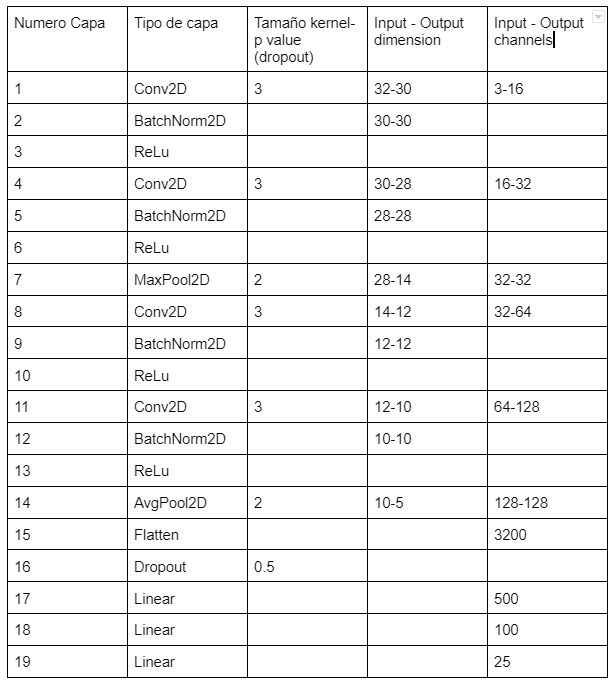

*   Se introducen nuevas capas convolucionales, lo que se traduce en más parametros entrenables y filtros que aprender, en definitiva más profundidad.
*   Se reduce el tamaño del kernel para que sea posible añadir estas capas de convolución y que el la imagen no se reduzca tan rápido. 
*   Se introducen capas de batch normalization después de las convoluciones que normalizan las entradas a estas capas. Estas capas tambien se entrenan y aprenden 2 parametros por cada canal de nuestro volumen. Normalizar la entrada en cada antes de cada capa hace que el entrenamiento sea mejor en muchos sentidos, por poner un ejemplo si hay un dato que es extremadamente grande y no se normaliza afectaría muy negativamente a la red, pero al normalizarlo su efecto es menor.
*   Se añaden más capas ocultas en la FCL y se aumenta el número de unidades por capa.
*   Se introduce Dropout con un valor de 0.5 en la FCL, esta mejora nos ayuda a reducir el sobreentrenamiento, pero como no tenemos mucho solo se mete al comienzo.






In [15]:
# Setting the model: Para las mejoras me voy a basar en las mejoras que han hecho otras redes neuronales
dbl = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct=0.1, seed=42),
    get_y = parent_label,
    item_tfms = [Resize(32)],
    batch_tfms=[Normalize.from_stats(*imagenet_stats),*aug_transforms(max_rotate=25.0)] # metemos normalizacion de datos y aumento de datos
    )

dls = dbl.dataloaders(path/'train', bs=256) #tamano del batch


impBaseNet = sequential( #Softmax lo hace sin tener que especificarlo
    
    nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3,3)), # 30x30x16
    nn.BatchNorm2d(num_features=16),
    nn.ReLU(),
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3)), # 28x28x32
    nn.BatchNorm2d(num_features=32),
    nn.ReLU(),

    nn.MaxPool2d(kernel_size=(2,2)), # 14x14x16
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3)), # 12x12x64
    nn.BatchNorm2d(num_features=64),
    nn.ReLU(),
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3)), # 10x10x128
    nn.BatchNorm2d(num_features=128),
    nn.ReLU(),

    nn.AvgPool2d(kernel_size=(2,2)), # 5x5x128

    nn.Flatten(), # no estaba haciendo esto y tenia un error que decia que no podian multiplicar 2 matrices
    nn.Dropout(0.5), 
    nn.Linear(in_features=3200, out_features=500),
    #nn.Dropout(0.3),
    nn.Linear(in_features=500, out_features=100),
    #nn.Dropout(0.3),
    nn.Linear(in_features=100, out_features=25),
)

from torch.nn.modules.loss import CrossEntropyLoss

learn = Learner(dls, impBaseNet, loss_func=CrossEntropyLossFlat(), metrics=[accuracy,error_rate])

learn.summary()

Sequential (Input shape: 256 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     256 x 16 x 30 x 30  
Conv2d                                    448        True      
BatchNorm2d                               32         True      
ReLU                                                           
____________________________________________________________________________
                     256 x 32 x 28 x 28  
Conv2d                                    4640       True      
BatchNorm2d                               64         True      
ReLU                                                           
____________________________________________________________________________
                     256 x 32 x 14 x 14  
MaxPool2d                                                      
____________________________________________________________________________
                     256 x 64 x 12 x 12  
Conv2d                                    184

Para finalizar donde se entrena el modelo tenemos la opción de introducir algunos callbacks. Entre ellos uno es la opcion de introducir la mejora de Early Stopping que es de gran ayuda para entrenar, esta opción hace que el Learner pare el entrenamiento antes de entrar en un sobreajuste. En concreto tiene un parametro _patience_ que define cuantas épocas sin mejorar el error de validación se permiten en el entrenamiento. Es decir, en todo momento almacenamos el mejor valor de valid_loss y si este no se mejora, no encontramos un valor menor, el Learner para el entrenamiento y restablece los pesos de aquel que dió el valid_loss menor.

5.248074739938602e-05


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,3.216934,3.201028,0.069600,0.930400,00:15
1,3.198904,3.170264,0.101600,0.898400,00:15
2,3.176894,3.134216,0.114400,0.885600,00:17
3,3.144159,3.087233,0.133600,0.866400,00:15
4,3.102381,3.023275,0.153600,0.846400,00:15
5,3.046071,2.942183,0.168800,0.831200,00:15
6,2.970897,2.843214,0.191200,0.808800,00:15
7,2.881959,2.733992,0.208800,0.791200,00:15
8,2.779523,2.631181,0.223200,0.776800,00:15
9,2.678651,2.539756,0.238400,0.761600,00:15


Better model found at epoch 0 with valid_loss value: 3.2010276317596436.


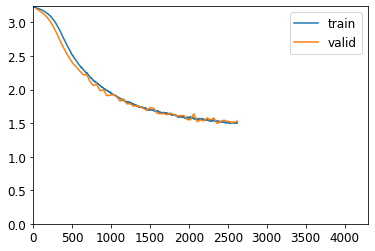

Better model found at epoch 1 with valid_loss value: 3.1702637672424316.
Better model found at epoch 2 with valid_loss value: 3.1342155933380127.
Better model found at epoch 3 with valid_loss value: 3.087232828140259.
Better model found at epoch 4 with valid_loss value: 3.023275375366211.
Better model found at epoch 5 with valid_loss value: 2.942183494567871.
Better model found at epoch 6 with valid_loss value: 2.8432137966156006.
Better model found at epoch 7 with valid_loss value: 2.733992099761963.
Better model found at epoch 8 with valid_loss value: 2.63118052482605.
Better model found at epoch 9 with valid_loss value: 2.5397558212280273.
Better model found at epoch 10 with valid_loss value: 2.4547340869903564.
Better model found at epoch 11 with valid_loss value: 2.382925510406494.
Better model found at epoch 12 with valid_loss value: 2.3319599628448486.
Better model found at epoch 13 with valid_loss value: 2.273280143737793.
Better model found at epoch 14 with valid_loss value: 2

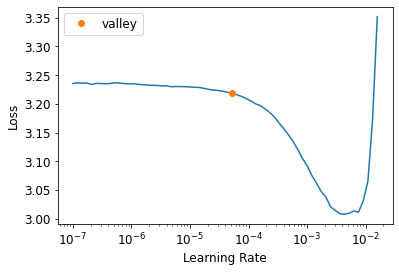

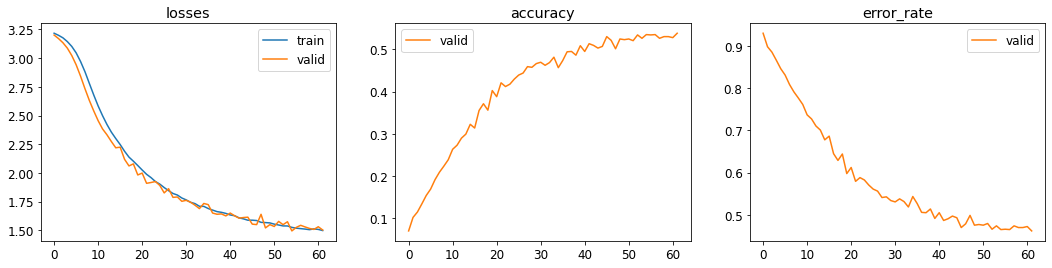

In [16]:
lr = learn.lr_find()

print(lr[0])
cbs=[SaveModelCallback(), ShowGraphCallback(),EarlyStoppingCallback(min_delta=0.01, patience=7)]
learn.fit_one_cycle(n_epoch=100, lr_max=lr[0], cbs=cbs)

learn.recorder.plot_metrics()

Una vez hemos entrenado el modelo tenemos que comprobar como funciona con el conjunto de test. 

Creamos un objeto con todas las imagenes de test y generamos el Dataloader a partir de estas imagenes.


In [17]:
test_files = [fn for fn in sorted((path/'test').glob('**/*')) if fn.is_file()]
test_dl = learn.dls.test_dl(test_files,with_labels=True)
# We perform prediction on this bunch of data (in this case, the validation set)
preds, targs, _ = learn.get_preds(dl=test_dl, with_decoded=True)

In [18]:
# We compute accuracy
acc = accuracy(preds, targs)
print('The test accuracy is : ', round(float(acc)*100, 4), '%')

The test accuracy is :  53.12 %


La precisión de este modelo mejorado es de 50.48%, un porcentaje algo mejor que el de BaseNet, pero todavía poco útil en el mundo real. Esta precisión esta entorno al valor que nos pedian y estoy satisfecho con los resultados aunque posiblemente se podría mejorar por ejemplo utilizando imagenes de mayor tamaño y introduciendo más capas convolucionales.

Number of test examples: 2500


Test Accuracy
53.12


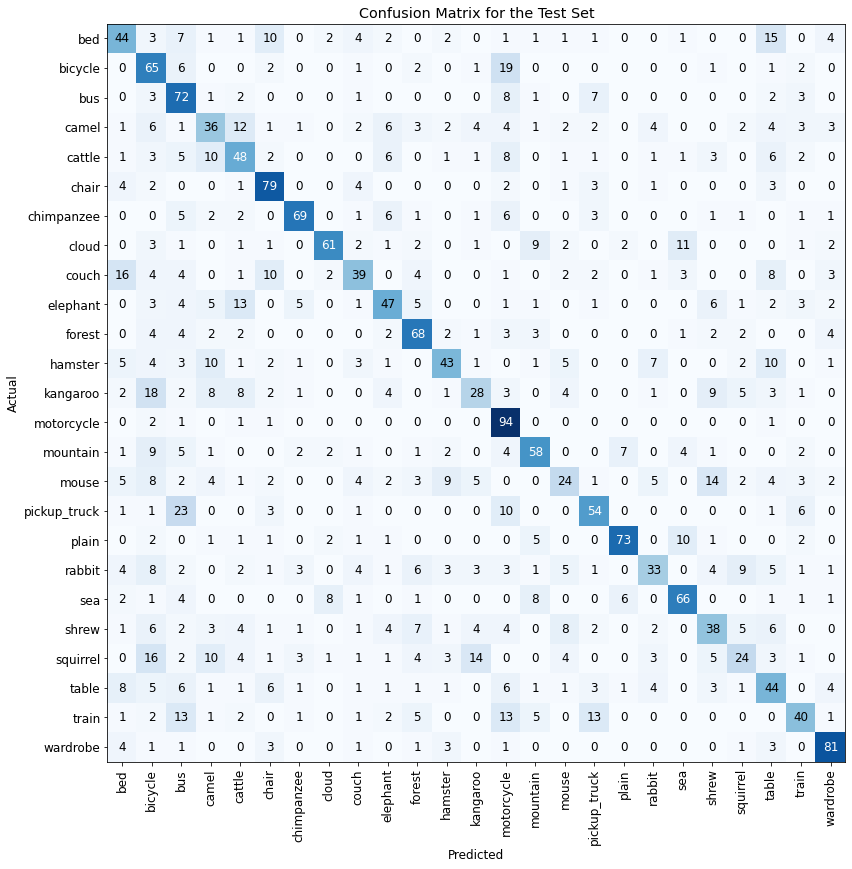

In [19]:
# We compute the confusion matrix
interp = ClassificationInterpretation.from_learner(learn, 1, test_dl)
cm = interp.confusion_matrix()
print('Number of test examples:', np.sum(cm))
interp.plot_confusion_matrix(figsize=(12, 12),title='Confusion Matrix for the Test Set')
print('Test Accuracy') 
print(np.sum(np.diagonal(cm))/np.sum(cm)*100)

Esta matriz nos muestra estadísticas de las clasificaciones que hace el conjunto de test. Se puede ver que los valores más grandes por lo general esta en la diagonal principal, esto indica que clasifica bien por lo general. Las categorias que más le cuesta nuestro clasificador son las ardillas (squirrel), los conejos (rabbit), los ratones (mouse) y las zariguellas (possum). Otra información curiosa que se puede extraer de esta matriz es la categoria con la que mas confunden nuestras imagenes, por ejemplo el tigre ha sido confundido con por un leopardo un total de 20 veces.

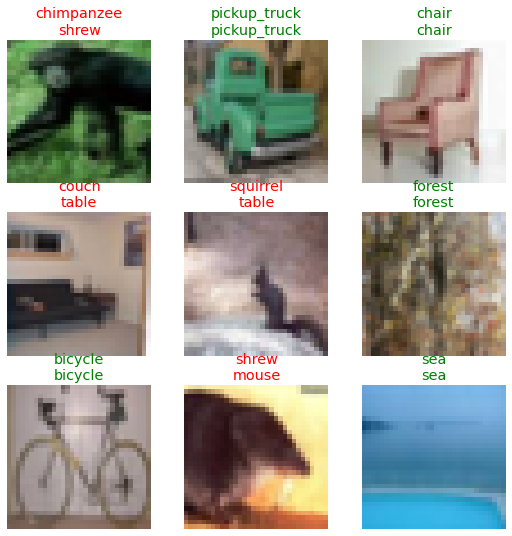

In [20]:
learn.show_results()

---



---



---

# **Exercise  3: Model transfer and fine-tuning with ResNet18 for the Caltech-UCSD Birds-200-2011 database (3 points)**
In this exercise we will work with the Caltech-UCSD Birds-200-2011 dataset (https://www.vision.caltech.edu/datasets/cub_200_2011/). This dataset consists of 11,788 images of 200 bird species. It has 200 classes, with 5,994 for training and 5,794 for testing. Again, 10% of the training set will be left for validation. Read the dataset using the provided functions.

We will use the ResNet18 network model already pre-trained with ImageNet, it can be downloaded from the Fastai Model repository. You have to:
1. **Use ResNet18 as a feature extractor** for the Caltech-UCSD Birds-200-2011 dataset. To do this we will remove at least the head of the downloaded model, we will add some additional convolutional blocks and a new head. Specifically, students have to perform the following experiments:
    
    **1.1.** Download and adapt the ResNet18 model trained with ImageNet to the Caltech-UCSD dataset, retrain this new fully connected layer, and estimate the network performance. 
    
    **1.2.** Remove the head of the model and add new convolutional blocks and a new head designed by you. Retrain your model with Caltech-UCSD. 
    
    **1.3.** Compare the results obtained in 1.2 and 1.1.

  Remember that, during training, you have to freeze the weights in the feature extraction blocks.

2. **Make a fine-tuning of the entire ResNet18 network** for  Caltech-UCSD. Remember that the number of epochs for fine-tuning must be small.





In [21]:
# https://docs.fast.ai/data.external.html
path = untar_data(URLs.CUB_200_2011)

In [22]:
# We explore a little bit the folders and number of examples.
# train_test_split.txt contains the information about which images are for training and which ones are for testing
print(path)
print(path.ls())
print((path/'CUB_200_2011/').ls())
train_test_split = np.loadtxt('/root/.fastai/data/CUB_200_2011/CUB_200_2011/train_test_split.txt',dtype=int)

print('Number of testing examples: ', (train_test_split[:,1]== 0).sum())
print('Number of training examples: ', (train_test_split[:,1]== 1).sum())
print(train_test_split)

/root/.fastai/data/CUB_200_2011
[Path('/root/.fastai/data/CUB_200_2011/CUB_200_2011'), Path('/root/.fastai/data/CUB_200_2011/attributes.txt')]
[Path('/root/.fastai/data/CUB_200_2011/CUB_200_2011/train_test_split.txt'), Path('/root/.fastai/data/CUB_200_2011/CUB_200_2011/bounding_boxes.txt'), Path('/root/.fastai/data/CUB_200_2011/CUB_200_2011/images'), Path('/root/.fastai/data/CUB_200_2011/CUB_200_2011/image_class_labels.txt'), Path('/root/.fastai/data/CUB_200_2011/CUB_200_2011/parts'), Path('/root/.fastai/data/CUB_200_2011/CUB_200_2011/attributes'), Path('/root/.fastai/data/CUB_200_2011/CUB_200_2011/README'), Path('/root/.fastai/data/CUB_200_2011/CUB_200_2011/images.txt'), Path('/root/.fastai/data/CUB_200_2011/CUB_200_2011/classes.txt')]
Number of testing examples:  5794
Number of training examples:  5994
[[    1     0]
 [    2     1]
 [    3     0]
 ...
 [11786     0]
 [11787     1]
 [11788     0]]


In [23]:
# images.txt contains the numbered list of all images. Combining the information in images.txt and train_test_split.txt we can 
# get the actual images for training and test. First, we read the images.txt file. 
with open('/root/.fastai/data/CUB_200_2011/CUB_200_2011/images.txt') as file:
    images_list = file.readlines()
    images_list = [line.rstrip() for line in images_list]
print(images_list)

['1 001.Black_footed_Albatross/Black_Footed_Albatross_0046_18.jpg', '2 001.Black_footed_Albatross/Black_Footed_Albatross_0009_34.jpg', '3 001.Black_footed_Albatross/Black_Footed_Albatross_0002_55.jpg', '4 001.Black_footed_Albatross/Black_Footed_Albatross_0074_59.jpg', '5 001.Black_footed_Albatross/Black_Footed_Albatross_0014_89.jpg', '6 001.Black_footed_Albatross/Black_Footed_Albatross_0085_92.jpg', '7 001.Black_footed_Albatross/Black_Footed_Albatross_0031_100.jpg', '8 001.Black_footed_Albatross/Black_Footed_Albatross_0051_796103.jpg', '9 001.Black_footed_Albatross/Black_Footed_Albatross_0010_796097.jpg', '10 001.Black_footed_Albatross/Black_Footed_Albatross_0025_796057.jpg', '11 001.Black_footed_Albatross/Black_Footed_Albatross_0023_796059.jpg', '12 001.Black_footed_Albatross/Black_Footed_Albatross_0086_796062.jpg', '13 001.Black_footed_Albatross/Black_Footed_Albatross_0049_796063.jpg', '14 001.Black_footed_Albatross/Black_Footed_Albatross_0006_796065.jpg', '15 001.Black_footed_Albatr

In [24]:
# We check if all classes are more or less equally well represented. 
classes = (path/'CUB_200_2011/images/').ls()
print('Number of examples per class')
for i in range(len(classes)):
  print(len(classes[i].ls()), end=" ")

Number of examples per class
60 52 59 60 60 41 60 60 60 59 60 60 60 60 60 59 60 59 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 59 59 56 60 60 60 50 60 60 59 60 60 60 60 60 60 59 60 60 58 60 60 60 60 60 56 60 60 60 59 60 59 60 58 59 60 60 60 50 59 60 60 60 59 60 50 59 59 60 60 60 59 60 60 60 60 44 60 60 48 60 56 60 60 53 60 60 60 60 60 60 60 60 57 60 60 60 60 60 59 58 60 59 60 60 60 60 60 60 59 60 60 53 60 60 60 58 60 60 59 60 60 60 59 60 60 60 58 51 57 59 49 60 60 59 59 60 60 45 50 60 60 60 60 60 60 59 59 60 60 60 60 60 60 60 59 60 59 60 58 60 59 59 60 60 60 60 60 59 60 53 60 60 60 60 60 

In [25]:
print(path)
import shutil, os
# If we already have these folders, we remove them because we want to create them from scratch
if os.path.isdir('/root/.fastai/data/CUB_200_2011/train'):
  shutil.rmtree('/root/.fastai/data/CUB_200_2011/train')
if os.path.isdir('/root/.fastai/data/CUB_200_2011/test'):
  shutil.rmtree('/root/.fastai/data/CUB_200_2011/test')

# We copy all images in two folders (train and test). Initially, both folders contain the same information.
shutil.copytree('/root/.fastai/data/CUB_200_2011/CUB_200_2011/images','/root/.fastai/data/CUB_200_2011/train')
shutil.copytree('/root/.fastai/data/CUB_200_2011/CUB_200_2011/images','/root/.fastai/data/CUB_200_2011/test')

/root/.fastai/data/CUB_200_2011


'/root/.fastai/data/CUB_200_2011/test'

In [26]:
# Now we remove from training those images belonging to test, and we remove
# from test those images belonging to train. 
import os 
for i in range(len(train_test_split)):
    if train_test_split[i,1]==0: #test image
       os.remove(path/'train'/images_list[i].rsplit(' ')[1]) #we remove it from train
    if train_test_split[i,1]==1: #train image
      os.remove(path/'test'/images_list[i].rsplit(' ')[1]) #we remove it from test

In [27]:
# We list the number of images in the folders to check if we actually have 5,994 images for training and 5,794 for testing
files_train = get_image_files(path/'train')
files_test = get_image_files(path/'test')
print('Total training images: ', len(files_train))
print('Total test images: ', len(files_test))

Total training images:  5994
Total test images:  5794


# **Ejercicio 3.1.1**
# *Solución:*

Se crea el Datablock con bloques en forma de par imagen-categoría, se deja el 10% del conjunto para validación, se indica que la etiqueta proviene del nombre del directorio y por ultimo se hace un rescalado a 224, que es el tamaño original de resnet18.

Después se define el Dataloader con el path de entrenamiento y con tamaño del batch, en este caso he escogido un valor pequeño, para que nuestro modelo aprenda rápido.

A continuación he definido el head que vamos a utilizar, se trata capa Fully Connected solo con una única capa oculta. Esta capa tiene una entrada de 25088, las que vienen de resnet18, y una salida de 200, que es el número de categorias que podemos clasificar. Para ser sincero he intentado antes crear un head con varias capas ocultas pero no he sido capaz de entrenarlo, ni el accuracy ni el error cambiaban.Luego he probado diferentes configuraciones pero la única que he sido capaz de entrenar ha sido esta que solo tiene un capa oculta.

Se carga el modelo en la variable _model_ y se llama a la función vision_learner() con el modelo y el Dataloader y nos devuelve un objeto entrenable. Esta llamada da la opción de elegir un head personalizado, por tanto es aqui donde indico que use nuestro head. Si no se usa un head personalizado vision_learner genería uno por defecto.

Por último se lanza el entrenamiento con la política fit_one_cycle del Learner, que en este caso funciona de una forma particular que vamos a comentar a continuación.

3.630780702224001e-05


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,7.392755,6.675142,0.018364,0.981636,00:46
1,6.154523,5.048078,0.070117,0.929883,00:40
2,4.641112,3.924686,0.163606,0.836394,00:40
3,3.371454,3.402220,0.245409,0.754591,00:44
4,2.498621,3.074039,0.280467,0.719533,00:46
5,1.910560,2.940039,0.323873,0.676127,00:41
6,1.565250,2.882010,0.328881,0.671119,00:38
7,1.382039,2.879203,0.330551,0.669449,00:38


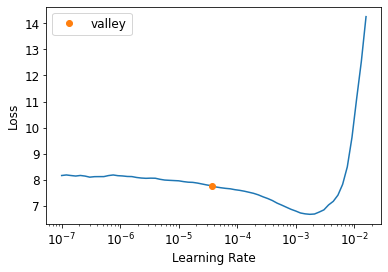

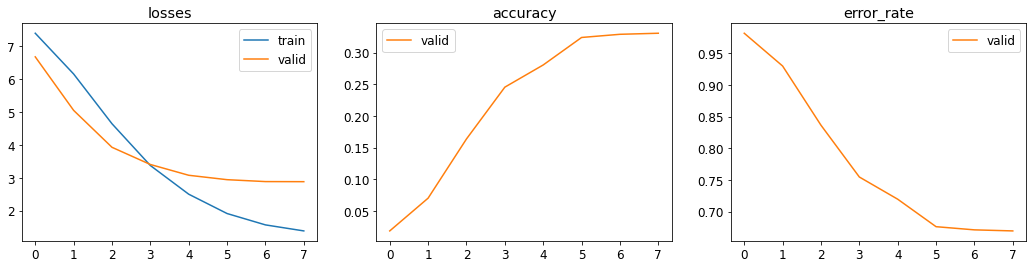

In [29]:
#ejercicio 3.1.1
dbl = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct=0.1, seed=42),
    get_y = parent_label,
    item_tfms = [Resize(224)] # hacer resize correcto
    )

dls = dbl.dataloaders(path/'train', bs=128)

my_head = nn.Sequential(
    nn.Flatten(),
    nn.Linear(25088,200)
)

model = fastai.vision.models.resnet18
learn = vision_learner(dls, model, metrics=[accuracy,error_rate], loss_func=CrossEntropyLossFlat(), custom_head=my_head)
learn.summary()

lr = learn.lr_find()
print(lr[0])
learn.fit_one_cycle(n_epoch=8, lr_max=lr[0])
learn.recorder.plot_metrics()

Antes de comentar los resultados podemos visualizar las capas que realmente estan siendo entrenadas. Ninguna capa convolucional, solo las de Batch Normalization y nuestro head.

In [30]:
learn.summary()

Sequential (Input shape: 128 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     128 x 64 x 112 x 11 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     128 x 64 x 56 x 56  
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                     

In [31]:
test_dl = learn.dls.test_dl(files_test,with_labels=True)
# We perform prediction on this bunch of data (in this case, the validation set)
preds, targs, _ = learn.get_preds(dl=test_dl, with_decoded=True)

In [32]:
acc = accuracy(preds, targs)
print('The test accuracy is : ', round(float(acc)*100, 4), '%')

The test accuracy is :  33.2931 %


Sobre el conjunto de test obtenemos uno resultados muy pobres, 33.29% de accuracy. En teoría en el ejercicio 3.1.2 esto resultados deberian ser batidos ya que podemos usar capas convolucionales que se podrán entrenar.

# **Ejercicio 3.1.2**
# *Solución*

En este caso se utiliza el mismo Datablock y Dataloader que anteriormente.

El nuevo head que se ha creado es el siguiente:

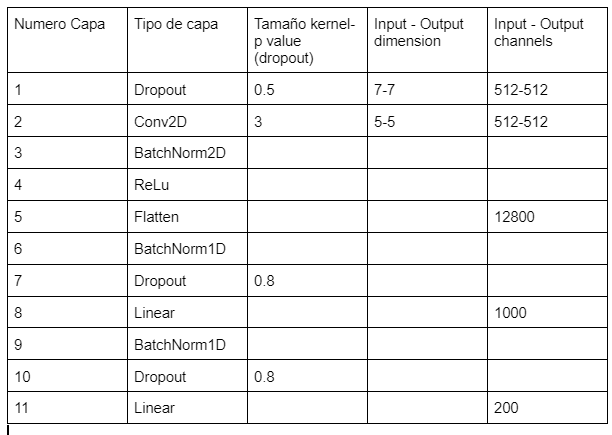

La red inicialmente no tenía varias capas, pero sobreajustaba muy rápido y por ello he metido capas de Dropout y de Batch Normalization que han mejorado el entrenamiento notablemente.

Además como se trata de una red más compleja he decidido introducir Early Stopping en el entrenamiento con un _patience_ igual a 3 y 25 épocas como máximo. El entrenamiento también se hará con la estrategia One Cycle para acelerarlo. 

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f8a9aeaeee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f8a9aeaeee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

0.00363078061491251


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,8.776520,4.267637,0.141903,0.858097,00:39
1,6.531023,2.972278,0.295493,0.704508,00:39
2,4.868447,2.373393,0.370618,0.629382,00:44


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f8a9aeaeee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f8a9aeaeee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Better model found at epoch 0 with valid_loss value: 4.267637252807617.


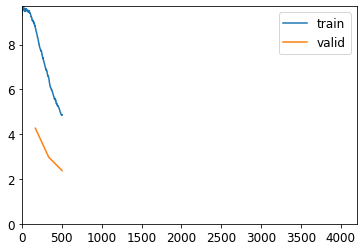

Better model found at epoch 1 with valid_loss value: 2.972277879714966.
Better model found at epoch 2 with valid_loss value: 2.3733925819396973.


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,8.776520,4.267637,0.141903,0.858097,00:39
1,6.531023,2.972278,0.295493,0.704508,00:39
2,4.868447,2.373393,0.370618,0.629382,00:44
3,4.223830,2.421895,0.363940,0.636060,00:40
4,3.967006,2.379862,0.385643,0.614357,00:41
5,3.783592,2.123439,0.414023,0.585977,00:39
6,3.552085,2.039606,0.477462,0.522538,00:38
7,3.187990,2.038760,0.459098,0.540901,00:39
8,2.805814,1.825026,0.510851,0.489149,00:41
9,2.474506,1.695809,0.527546,0.472454,00:39


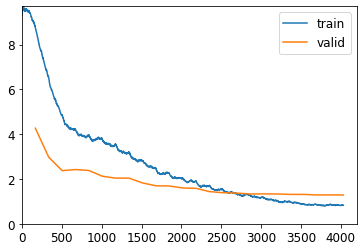

Better model found at epoch 5 with valid_loss value: 2.123438835144043.
Better model found at epoch 6 with valid_loss value: 2.0396063327789307.
Better model found at epoch 7 with valid_loss value: 2.038759708404541.
Better model found at epoch 8 with valid_loss value: 1.8250263929367065.
Better model found at epoch 9 with valid_loss value: 1.6958088874816895.
Better model found at epoch 10 with valid_loss value: 1.689064860343933.
Better model found at epoch 11 with valid_loss value: 1.5990557670593262.
Better model found at epoch 12 with valid_loss value: 1.583397388458252.
Better model found at epoch 13 with valid_loss value: 1.4376153945922852.
Better model found at epoch 14 with valid_loss value: 1.3875163793563843.
Better model found at epoch 15 with valid_loss value: 1.3727967739105225.
Better model found at epoch 16 with valid_loss value: 1.3312939405441284.
Better model found at epoch 18 with valid_loss value: 1.3306331634521484.
Better model found at epoch 19 with valid_loss 

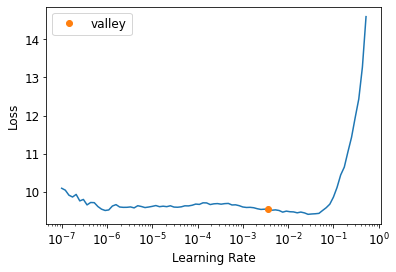

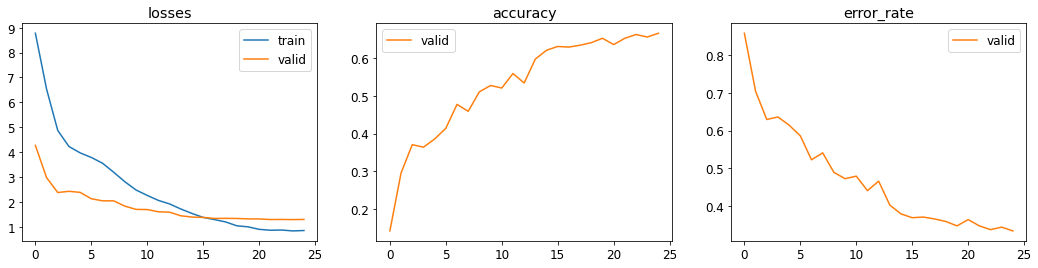

In [36]:
#ejercicio 3.1.2
dbl = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct=0.1, seed=42),
    get_y = parent_label,
    item_tfms = [Resize(224)] # hacer resize correcto
    )

dls = dbl.dataloaders(path/'train', bs=32)

my_head = nn.Sequential(
    
    nn.Dropout(0.5),
    nn.Conv2d(512, 512, 3), # 5x5x512
    nn.BatchNorm2d(512),
    nn.ReLU(),

    nn.Flatten(),   nn.BatchNorm1d(12800), nn.Dropout(0.8),
    nn.Linear(12800,1000),
    nn.BatchNorm1d(1000), nn.Dropout(0.8),
    nn.Linear(1000,200)
)

cbs=[SaveModelCallback(), ShowGraphCallback(),EarlyStoppingCallback(min_delta=0.01, patience=3)]
model = fastai.vision.models.resnet18
learn = vision_learner(dls, model, metrics=[accuracy,error_rate], loss_func=CrossEntropyLossFlat(), custom_head=my_head, cbs=cbs)

lr = learn.lr_find()
print(lr[0])
learn.fit_one_cycle(n_epoch=25, lr_max=lr[0])
learn.recorder.plot_metrics()

In [37]:
learn.summary()

Sequential (Input shape: 32 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 112 x 112 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                      

In [38]:
test_dl = learn.dls.test_dl(files_test,with_labels=True)
# We perform prediction on this bunch of data (in this case, the validation set)
preds, targs, _ = learn.get_preds(dl=test_dl, with_decoded=True)

In [39]:
acc = accuracy(preds, targs)
print('The test accuracy is : ', round(float(acc)*100, 4), '%')

The test accuracy is :  67.5354 %


En este caso obtenemos un accuracy del 67.53% sobre en conjunto de teset, el cual es muy buen resultado y que sinceramente no esperaba tan bueno.

# **Ejercicio 3.1.3**



Comparando el accuracy tenemos claro que el modelo con capas convolucionales es muy superior al modelo de de la fully connected layer. Lamentablemente creo que estos resultados están muy condicionados por el problema que tuve en el ejercicio 3.1.1 y si hubiera metido alguna capa más a la FCL no habría tantisima diferencia de accuracy aunque me imagino que el head con convoluciones seguiría siendo el mejor. 

También creo que no hemos podido sacar todo el jugo al entrenar la FCL porque tampoco hemos podido meter capas que regularicen y por tanto para evitar el sobreajuste he tenido que jugar un poco con el número de épocas y con el batch_size. En cambio el entrenamiento del head del 3.1.2 ha sido un entrenamiento muy bueno que vemos que no sobreajusta apenas.

Sobre el uso de resnet me parece una gran idea el usar este modelo ya entrenado como extractor de caraterísticas, ya que tenemos un gran modelo bien entrenado es lo suyo hacerle uso. 

# **Ejercicio 3.2**

# *Solución*

Definimos el Datablock con la misma configuración que venimos usando y luego definimos el Dataloader con un batch size de 256, este es un tamaño mediano que hará mayor uso de memoria pero a parte hará que el modelo aprenda caracteristicas más generales del conjunto de entrenamiento. Para un entrenamiento de 10 épocas podemos ver que es un batch size. Sabemos que los parámetros son buenos por que al final el error de validación da saltos muy pequeñitos pero la red no esta sobreentrenada.

Definimos el Learner con el Datablock, el Dataloader, y con función de error el CrossEntropyLossFlat.

El entrenamiento se hace con fine_tune, esta es una función que entrena de una forma especial ya que primero congela todas las capas menos el head, y hace un entrenamiento de una época y luego descongela las capas y hace entrenamiento de todo la red.

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,6.506259,3.996362,0.163606,0.836394,00:38


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,4.458641,3.491956,0.230384,0.769616,00:42
1,3.907660,2.660178,0.368948,0.631052,00:48
2,3.225762,2.069406,0.475793,0.524207,00:42
3,2.608177,1.794279,0.530885,0.469115,00:42
4,2.085031,1.635968,0.560935,0.439065,00:40
5,1.676807,1.565645,0.569282,0.430718,00:40
6,1.350084,1.521182,0.585977,0.414023,00:40
7,1.108139,1.501496,0.599332,0.400668,00:43
8,0.931877,1.486106,0.611018,0.388982,00:40
9,0.805367,1.485458,0.604341,0.395659,00:41


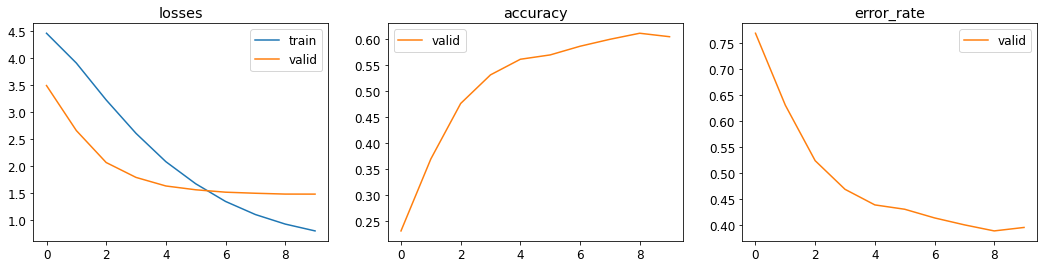

In [34]:
#ejercicio 3.2
#usar fine tuning

dbl = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct=0.1, seed=42),
    get_y = parent_label,
    item_tfms = [Resize(224)]
    )

dls = dbl.dataloaders(path/'train', bs=256)

model = fastai.vision.models.resnet18
learn = vision_learner(dls, model, metrics=[accuracy,error_rate], loss_func=CrossEntropyLossFlat())

#lr = learn.lr_find()
learn.fine_tune(10)
learn.recorder.plot_metrics()

A continuación se puede comprobar que las capas de convolución ahora están marcadas como trainable y de hecho ahora se entrena todo el modelo.

In [35]:
learn.summary()

Sequential (Input shape: 256 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     256 x 64 x 112 x 11 
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     256 x 64 x 56 x 56  
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                     

In [40]:
test_dl = learn.dls.test_dl(files_test,with_labels=True)
# We perform prediction on this bunch of data (in this case, the validation set)
preds, targs, _ = learn.get_preds(dl=test_dl, with_decoded=True)

In [ ]:
acc = accuracy(preds, targs)
print('The test accuracy is : ', round(float(acc)*100, 4), '%')

---



---



---

# **Bonus. (3 points)**  

There are many other possibilities to improve the *BaseNet* model over CIFAR100 using suitable combinations of layers. Feel free to try your own ideas, or those interesting machine learning and computer vision approaches you've read about. Student proposals are expected for discussion and clear definition. Each proposal will be evaluated based on its innovation, complexity, and good use of PyTorch+Fastai. We will also take the mastering of the libraries used in the experiment into consideration.

**Note 1**: The Bonus will only be taken into account if, at least, 75% of the compulsory part is correct. 

**Note 2**: Since Colab only offers limited computational resources, students must try to rationally limit training time, memory consumption and size of the models used. The use of good coding practices is highly advised.

In [ ]:
# We get the CIFAR100 dataset
path = untar_data(URLs.CIFAR_100,force_download=True)

In [ ]:
# The CIFAR_100 dataset, as well as the MNIST dataset, follows a common layout for machine learning datasets: 
# separate folders for the training set and the validation set (and/or test set). 
# Let's see what's inside both the training and test sets
print(path)
print(path.ls())
print((path/'train').ls())
print((path/'test').ls())
train_classes = (path/'train').ls()
test_classes = (path/'test').ls()
print(len(train_classes))

In [ ]:
files_train = get_image_files(path/'train')
files_test = get_image_files(path/'test')
print('Total training images: ', len(files_train))
print('Total test images: ', len(files_test))

In [ ]:
#https://stackoverflow.com/questions/185936/how-to-delete-the-contents-of-a-folder
import shutil
number_of_classes_to_keep = 25
number_of_superclasses_to_keep = int(number_of_classes_to_keep/5)
print('SUPERCLASSES DELETED:')
for i in range(number_of_superclasses_to_keep,len(train_classes)):
  print(train_classes[i])
  shutil.rmtree(train_classes[i]) 
print('SUPERCLASSES KEPT:')
for i in range(number_of_superclasses_to_keep):
  print(train_classes[i])

In [ ]:
# We also remove the same superclasses from the test set
for i in range(number_of_superclasses_to_keep,len(test_classes)):
  print(test_classes[i])
  shutil.rmtree(test_classes[i]) 

In [ ]:
print(path)
train_classes = (path/'train').ls()
test_classes = (path/'test').ls()
print(len(train_classes))
print(len(test_classes))

In [ ]:
files_train = get_image_files(path/'train')
files_test = get_image_files(path/'test')
print('Total training images: ', len(files_train))
print('Total test images: ', len(files_test))

In [ ]:
dbl = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct=0.1, seed=42),
    get_y = parent_label,
    item_tfms = [Resize(32)],
    batch_tfms=[Normalize.from_stats(*imagenet_stats),*aug_transforms(max_rotate=25.0)] # metemos normalizacion de datos y aumento de datos
    )

dls = dbl.dataloaders(path/'train', bs=256) #tamano del batch

impBaseNet = sequential( #Softmax lo hace sin tener que especificarlo
    
    nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3,3)), # 30x30x16
    nn.BatchNorm2d(num_features=16),
    nn.ReLU(),
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3)), # 28x28x32
    nn.BatchNorm2d(num_features=32),
    nn.ReLU(),

    nn.MaxPool2d(kernel_size=(2,2)), # 14x14x16
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3)), # 12x12x64
    nn.BatchNorm2d(num_features=64),
    nn.ReLU(),
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3)), # 10x10x128
    nn.BatchNorm2d(num_features=128),
    nn.ReLU(),

    nn.AvgPool2d(kernel_size=(2,2)), # 5x5x128

    nn.Flatten(), # no estaba haciendo esto y tenia un error que decia que no podian multiplicar 2 matrices
    nn.Dropout(0.5),
    nn.Linear(in_features=3200, out_features=500),
    nn.Linear(in_features=500, out_features=100),
    nn.Linear(in_features=100, out_features=25),
)

from torch.nn.modules.loss import CrossEntropyLoss

learn = Learner(dls, impBaseNet, loss_func=CrossEntropyLossFlat(), metrics=[accuracy,error_rate])

learn.summary()

In [ ]:
lr = learn.lr_find()

print(lr[0])
cbs=[SaveModelCallback(), ShowGraphCallback(),EarlyStoppingCallback(min_delta=0.01, patience=7)]
learn.fit_one_cycle(n_epoch=100, lr_max=lr[0], cbs=cbs)

learn.recorder.plot_metrics()